# Automated traiding strategy - Data project
In this project we will investigates the feasibility of predicting companies' future stock prices and achieving an abnormal excess return. The project will focus on companies in the Dow Jones index from the year 2013 to 2019. We will use an API from financial modelling prep, which allows us to access key financial data for all the companies, with a primary focus on P/S, P/B, P/E, DCF and WACC. To evaluate the model, the project compares its predictions against actual market outcomes. Here we determine a buy or sell recommendation for the year 2014-2019 for the ratios and only recommend for the year 2019 with the DCF and WACC variables. The project will compare predictions against actual outcomes for all the different financial variables. 

The API is free to use after creating an account but has a limit of 250 requests a day. Therefore, to access all 30 companies in the Dow Jones index, one must wait 24 hours to get the data for the next companies or create a second account. We used two accounts to get the data from the first 25 companies and then the last 5 companies. 

We saved the data in a CSV file to avoid having to wait 24 hours to get the data. Meaning, final_merger.csv contains all the financial variables and the profit_difference:more_years.csv and contains the profit difference for the years 2014-2019. 

## Theory
In this section, we will explain the theory behind the capital asset pricing model (CAPM) and how we construct the different financial variables.

# CAPM

The Capital Asset Pricing Model (CAPM) explains the relationship between an asset's expected return and its systematic risk, represented by the $\beta$ coefficient. Developed by Sharpe in 1964, the model posits that investors can mitigate unsystematic risk by maintaining a well-diversified portfolio of numerous assets. CAPM assumes that investors are rational and risk-averse, and that a risk-free asset exists, offering a constant interest rate without transaction costs or taxes.

According to the CAPM, a higher $\beta$ results in a higher expected return. This project will examine the CAPM theory by creating a long-short strategy based on two portfolios: purchasing a high-beta portfolio while simultaneously shorting a low-beta portfolio. Consequently, the average excess returns should yield a return greater than the risk-free rate, as indicated by Tidy Finance. This analysis will help determine whether it is possible to achieve abnormal excess returns based on a stock's $\beta$.

The CAPM can be expressed as:

$E[R_i] = R_f + \beta_i \dot (E[R_m]-R_f)$

In this equation, $E[R_i]$ represents the expected return, Rf denotes the risk-free rate, and $E[R_m] - R_f$ is the market risk premium. When $\beta > 1$ in equation (1), it signifies that a stock carries more risk compared to the market, and the opposite holds true for $\beta < 1$. The paper employs the subsequent formula to calculate $\beta$:

$\beta = \frac{Covariance(R_e, R_m)}{Variance(R_m)}$

In this formula, $R_e$ represents the return on a specific stock, while $R_m$ denotes the return on the entire market.


### Financial ratios
The following section discusses different valuation methods used to determine the intrinsic value of a company. These methods include price to earnings (P/E), price to book (P/B), price to sales (P/S), discounted cash flow (DCF), $\beta$, and weighted average cost of capital (WACC).

The P/E ratio reflects how much investors are willing to pay for each unit of a company's earnings. A high P/E ratio suggests that the company is overvalued, while a low P/E ratio indicates that it is undervalued. This projet will utilize the trailing P/E ratio, which divides the current share price by the total earnings per share in the past 12 months.

The P/B ratio evaluates whether a firm is overvalued or undervalued by comparing its market capitalization to its book value. Divide the company's current share price by its book value per share to obtain the P/B ratio.

The P/S ratio is used to compare a company's stock price to its revenue. A low P/S ratio may indicate that the stock is undervalued, while a ratio higher than the average could imply that the stock is overvalued.

The DCF method estimates the value of a company by predicting its future cash flows and discounting them to their present value. The project will use an unlevered DCF, which forecasts free cash flows before interest expense and interest income. The DCF analysis aims to value the company as a whole.

The WACC measures the average cost of financing a company's assets using both debt and equity sources. It indicates how much return a company needs to generate to satisfy its creditors and shareholders. This project will use a formula to calculate the WACC and is given by,

$WACC = \left(\frac{V_E}{V_E + V_D}\right)R_e + \left(\frac{V_D}{V_E + V_D}\right)R_d(1 - \tau_c)$

where $R_e$ is the cost of equity, $R_d$ is the cost of debt, $V_E$ is the market value of the firm's equity, $V_D$ is the market value of the firm's debt, and $tau_c$ is corporation tax.

Overall, this project will compare the different valuation methods against other companies in the same industry to determine if a company is overvalued or undervalued.

## Import files

In [1]:
# Relevant imports
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as pdr
import statsmodels.api as sm
import pandas as pd

# For parsing financial statements data from financialmodelingprep api
from urllib.request import urlopen
import json
import os
from pathlib import Path


In [2]:
# Settings to produce readable plots in a Jupyter notebook
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

# Used to fetch JSON data from a URL and parse it into a Python object.
def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Financialmodelingprep api url
base_url = "https://financialmodelingprep.com/api/v3/"

# Financialmodelingprep api key, get yourself a free version on their website: https://site.financialmodelingprep.com/
apiKey = "c4980cec7d8ac458173404bc538bfe2a"

# List of S&P 500 tickers
#tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']


# Tickers in the Dow Jones Index
tickers = ['AAPL', 'AMGN', 'AMZN', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'SPY']
#create a dataframe with the tickers
tickers = pd.DataFrame(tickers, columns=['ticker'])




## Get financial data from financialmodelingprep.com
This section accesses the data from the API. We have provided you with one free API key, which is able to run 20 tickers. To get all the data from Dow Jones index you must have a premium API key or two free API keys.

!!!DISCLAIMER: If you do not have access to a premium API key from financialmodelingprep.com you must create two free API keys to extract the data below. Only run this section if you have prepared two API keys and want to test whether the code works. Otherwise, skip this section since we have already provided you with the data in the CSV files. 

If you try to run it without these API keys it would say: HTTP Error 429: Too Many Requests.


In [3]:
# Storing elements from all_statements in a list
all_statements = []
# It can max run 20 tickers at a time, so run the code below 2 times with a new API key each time.
tickers_of_interest = tickers['ticker'].iloc[0:20].values.tolist() + ['SPY'] # Run this first

#tickers_of_interest = tickers['ticker'].iloc[25:31].values.tolist()   # Run this second

for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            #Income Statement
            income_statement = pd.DataFrame(get_jsonparsed_data(base_url+'income-statement/' + ticker + '?apikey=' + apiKey)) # Get income statement data from the API
            income_statement['date'] = pd.to_datetime(income_statement['date']) # Convert date to datetime
            income_statement['date'] = income_statement['date'].dt.year # Convert date to year
            income_statement = income_statement.set_index('date') # Set date as index
            income_statement = income_statement[~income_statement.index.duplicated(keep='first')] # Remove duplicate dates
            income_statement = income_statement.apply(pd.to_numeric, errors='coerce') # Convert all values to numeric
            income_statement.columns = income_statement.columns.str.replace('symbol', 'ticker') # Rename symbol to ticker
            income_statement = income_statement[income_statement.index <= 2018] # Keep only the years 2013-2018
            income_statement = income_statement[income_statement.index >= 2013] 
            income_statement['industry'] = get_jsonparsed_data(base_url+'profile/' + ticker + '?apikey=' + apiKey)[0]['industry'] # Get industry from the API
            income_statement['ticker'] = income_statement['ticker'].fillna(ticker) # Fill empty ticker values with the ticker name

            #Cash Flow
            cash_flow_statement = pd.DataFrame(get_jsonparsed_data(base_url+'cash-flow-statement/' + ticker + '?apikey=' + apiKey)) # Get Cash Flow statement data from the API
            cash_flow_statement['date'] = pd.to_datetime(cash_flow_statement['date'])
            cash_flow_statement['date'] = cash_flow_statement['date'].dt.year
            cash_flow_statement = cash_flow_statement.set_index('date')
            cash_flow_statement = cash_flow_statement[~cash_flow_statement.index.duplicated(keep='first')]
            cash_flow_statement = cash_flow_statement.apply(pd.to_numeric, errors='coerce') 
            cash_flow_statement = cash_flow_statement[cash_flow_statement.index <= 2018]
            cash_flow_statement = cash_flow_statement[cash_flow_statement.index >= 2013]

            #Balance
            balance_statement = pd.DataFrame(get_jsonparsed_data(base_url+'balance-sheet-statement/' + ticker + '?apikey=' + apiKey)) # Get Balance statement data from the API
            balance_statement['date'] = pd.to_datetime(balance_statement['date'])
            balance_statement['date'] = balance_statement['date'].dt.year
            balance_statement = balance_statement.set_index('date')
            balance_statement = balance_statement[~balance_statement.index.duplicated(keep='first')]
            balance_statement = balance_statement.iloc[::-1].apply(pd.to_numeric, errors='coerce')
            balance_statement = balance_statement[balance_statement.index <= 2018]
            balance_statement = balance_statement[balance_statement.index >= 2013]

            #Shareprice
            shareprice = pd.DataFrame(get_jsonparsed_data(base_url+ 'financial-ratios/' + ticker + '?apikey=' + apiKey)) # Get Shareprice data from the API
            shareprice = shareprice["ratios"].apply(pd.Series)
            shareprice['date'] = pd.to_datetime(shareprice['date'])
            shareprice['date'] = shareprice['date'].dt.year
            shareprice = shareprice.set_index('date')
            shareprice = shareprice[~shareprice.index.duplicated(keep='first')]
            shareprice = shareprice["investmentValuationRatios"].apply(pd.Series)
            shareprice = shareprice[shareprice.index <= 2018]
            shareprice = shareprice[shareprice.index >= 2013]

            #DCF
            dcf = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-discounted-cash-flow-statement/' + ticker + '?apikey=' + apiKey)) # Get DCF data from the API
            dcf['date'] = pd.to_datetime(dcf['date'])
            dcf['date'] = dcf['date'].dt.year
            dcf = dcf.set_index('date')
            dcf = dcf[~dcf.index.duplicated(keep='first')]
            dcf = dcf[dcf.index == 2018]
            dcf['ticker'] =dcf['symbol']
            dcf = dcf.drop(['symbol'], axis=1)
            
            #Market cap
            market_cap = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-market-capitalization/' + ticker + '?' 'limit=10000&' 'apikey=' + apiKey)) # Get Market cap data from the API
            market_cap['date'] = pd.to_datetime(market_cap['date'])
            market_cap['date'] = market_cap['date'].dt.year
            market_cap = market_cap.set_index('date')
            market_cap = market_cap[~market_cap.index.duplicated(keep='first')]
            market_cap = market_cap[market_cap.index == 2018]
            market_cap['ticker'] = ticker
            market_cap = market_cap.drop(['symbol'], axis=1)
            
            #Tax rate
            tc = pd.DataFrame(get_jsonparsed_data(base_url+ 'ratios/' + ticker + '?apikey=' + apiKey)) # Get Tax rate data from the API
            tc['date'] = pd.to_datetime(tc['date'])
            tc['date'] = tc['date'].dt.year
            tc = tc.set_index('date')
            tc = tc[~tc.index.duplicated(keep='first')]
            tc = tc[tc.index == 2018]
            tc = tc["effectiveTaxRate"].apply(pd.Series)
            tc = tc.rename(columns={0: 'eff_tax_rate'})
            tc['ticker'] = ticker

            #concatenate the dataframes balance_statement, cash_flow_statement, income_statement
            all_statement = pd.concat([income_statement, balance_statement, cash_flow_statement, shareprice, dcf, market_cap, tc], axis=1) 

            #Liquidity
            all_statement['equity_ratio'] = balance_statement['totalStockholdersEquity'] / balance_statement['totalAssets'] 

            #Leverage
            all_statement['debt_to_equity'] = balance_statement['totalLiabilities'] / balance_statement['totalStockholdersEquity']
            all_statement['debt_to_assets'] = balance_statement['totalLiabilities'] / balance_statement['totalAssets']
            all_statement['interest_coverage'] = (income_statement['incomeBeforeTax']-income_statement['interestIncome']) / income_statement['interestExpense']

            #profitability
            all_statement['gross_profit_margin'] = income_statement['grossProfit'] / income_statement['revenue']
            all_statement['operating_margin'] = income_statement['operatingIncome'] / income_statement['revenue']
            all_statement['return_on_equity'] = income_statement['netIncome'] / balance_statement['totalStockholdersEquity'] * 100
            all_statement['return_on_assets'] = income_statement['netIncome'] / balance_statement['totalAssets']

            all_statements.append(all_statement)
            
        except Exception as e: # if error, print ticker symbol and error message
            print(ticker, e)

# Concatenate the dataframes all_statements
final_df = pd.concat(all_statements)

# Remove duplicate columns
duplicate_columns = final_df.columns.duplicated()
final_df = final_df.loc[:, ~duplicate_columns]

#Beta %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# In this section we will calculate the beta of the stocks we are interested in

# First we get the stock price of the 'spy' index
stock_price = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + 'spy' + '?from=2013-01-01&to=2018-12-31&apikey=' + apiKey)) 
stock_price = stock_price["historical"].apply(pd.Series)
stock_price = stock_price.set_index('date')
stock_price['ticker'] = 'spy'
stock_price = stock_price[['adjClose', 'ticker']]

# Next, we get all the stock prices of the stocks we are interested in and we store them in a list called stock_list_beta
stock_list_beta = []
for ticker in tickers_of_interest:
    try:
        stock_price = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + ticker + '?from=2013-01-01&to=2018-12-31&apikey=' + apiKey))
        stock_price = stock_price["historical"].apply(pd.Series)
        stock_price = stock_price.set_index('date')
        stock_price['ticker'] = ticker
        stock_price = stock_price[['adjClose', 'ticker']]
        stock_list_beta.append(stock_price)
        
    except Exception as e:
        print(ticker, e)
stock_pd = pd.concat(stock_list_beta, ignore_index=False)   

# we pivot the dataframe so that the tickers are the columns
stock_pd = stock_pd.pivot(columns='ticker', values='adjClose')

data = stock_pd

# taking the log of the stock prices and drops NaN values
log_returns = np.log(data/data.shift())
log_returns.dropna(inplace=True)

# creating a loop to calculate the beta of each stock using the formula cov(x,y)/var(y)
beta_list = []
for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            cov = log_returns.cov()
            var = log_returns['SPY'].var()
            beta_ticker = cov.loc[ticker, 'SPY']/var
            beta_spy = cov.loc['SPY']/var

            # create a dataframe for the betas
            beta_df = pd.DataFrame({'ticker': [ticker], 'Beta': [beta_ticker]})

            # create a new column called date for 2018-12-31
            beta_df['date'] = 2018
            beta_df = beta_df.set_index('date')
            beta_list.append(beta_df)
        except Exception as e:
            print(ticker, e)
beta_df = pd.concat(beta_list, ignore_index=False)   
final_df = final_df.merge(beta_df, how='left', left_on=['date', 'ticker'], right_on=['date', 'ticker'] )


#Risk free rate %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# In this section we will calculate the risk free rate using 1 year treasury bills
start = datetime.datetime(2013, 12, 31)
end = datetime.datetime(2018, 12, 31)

dates = pd.date_range(start, end, freq='12M')

RF_rates = []

for date in dates:
    Treasury = pdr.DataReader(['TB1YR'], 'fred', date, date + pd.Timedelta(days=365))
    RF_rate = float(Treasury.iloc[-1])
    RF_rates.append(RF_rate/100)

RF_rates = pd.DataFrame(RF_rates, index=dates, columns=['RF_rate'])
RF_rates = RF_rates.sort_index(ascending=False)
RF_rates.index = RF_rates.index.year
final_df['RF_rate'] = RF_rates['RF_rate']

#spy_yearly_return %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# In this section we will calculate the yearly return of the spy index
spy_yearly_return = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + 'SPY' + '?from=1992-01-01&to=2018-12-31&apikey=' + apiKey))
spy_yearly_return = spy_yearly_return["historical"].apply(pd.Series)
spy_yearly_return = spy_yearly_return.set_index('date')
spy_yearly_return['ticker'] = 'SPY'
spy_yearly_return = spy_yearly_return[['adjClose',]]
spy_yearly_return.rename(columns={'adjClose': 'SPY'})
spy_yearly_return = (spy_yearly_return['adjClose'].iloc[0] - spy_yearly_return['adjClose'].iloc[-1])/spy_yearly_return['adjClose'].iloc[-1]

#Cost of debt %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ratings.htm 
#https://pages.stern.nyu.edu/~adamodar/New_Home_Page /valquestions/syntrating.htm
# In this section we will calculate the cost of debt using the interest coverage ratio and a table from stern.nyu.edu
# we use a function that defines the interest coverage ratio given the table from stern.nyu.edu
def cost_of_debt(interest_coverage):
    try:
        if interest_coverage >8.5:
            return 0.0069 
        elif interest_coverage > 6.5 and interest_coverage <= 8.5:
            return 0.0085
        elif interest_coverage > 5.5 and interest_coverage <= 6.5:
            return 0.0123
        elif interest_coverage > 4.25 and interest_coverage <= 5.5:
            return 0.0142
        elif interest_coverage > 3 and interest_coverage <= 4.25:
            return 0.0162
        elif interest_coverage > 2.5 and interest_coverage <= 3:
            return 0.02
        elif interest_coverage > 2.25 and interest_coverage <= 2.5:
            return 0.0242
        elif interest_coverage > 2 and interest_coverage <= 2.25:
            return 0.0313
        elif interest_coverage > 1.75 and interest_coverage <= 2:
            return 0.0455
        elif interest_coverage > 1.5 and interest_coverage <= 1.75:
            return 0.0526
        elif interest_coverage > 1.25 and interest_coverage <= 1.5:
            return 0.0737
        elif interest_coverage > 0.8 and interest_coverage <= 1.25:
            return 0.1157
        elif interest_coverage > 0.65 and interest_coverage <= 0.8:
            return 0.1578
        elif interest_coverage > 0.2 and interest_coverage <= 0.65:
            return 0.1750
        elif interest_coverage > -100000 and interest_coverage <= 0.2:
            return 0.2
    except Exception as e:
        print(f"An error occurred: {e}")
# We apply the function to the to the cost of debt column and add the risk free rate to it        
final_df['cost_of_debt']=final_df['interest_coverage'].apply(cost_of_debt)
final_df['cost_of_debt']=final_df['cost_of_debt']+final_df['RF_rate']

# Cost of equity %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# We calculate the cost of equity using the CAPM model
final_df['cost_of_equity'] = final_df['RF_rate'] + (final_df['Beta'] * (spy_yearly_return - final_df['RF_rate']))

#WACC %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# We calculate the weighted average cost of capital
wacc = (final_df['marketCap']/(final_df['marketCap']+final_df['totalDebt']))*final_df['cost_of_equity'] + (final_df['totalDebt']/(final_df['marketCap']+final_df['totalDebt']))*final_df['cost_of_debt']*(1-final_df['eff_tax_rate'])

# Use total debt as a proxy for market value of debt: https://site.financialmodelingprep.com/weighted-average-cost-of-capital
final_df['wacc'] = wacc

#sector %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# In this section we will get the sector of each company and append it to the final_df
sector_list = []
for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            sector = pd.DataFrame(get_jsonparsed_data(base_url+ 'profile/' + ticker + '?from=1992-01-01&to=2018-12-31&apikey=' + apiKey))
            sector = sector[['symbol', 'sector']]
            sector['ticker'] = sector['symbol']
            sector = sector.drop('symbol', axis=1)
            sector_list.append(sector)
        except Exception as e:
            print(ticker, e)
sector_df = pd.concat(sector_list, ignore_index=False)   
final_df = final_df.merge(sector_df, how='left', left_on=['ticker'], right_on=['ticker'] )
final_df.index = final_df.index

#DONE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#pd.set_option('display.max_columns', 10)
final_df [['wacc', 'sector', 'ticker', 'marketCap', 'totalDebt', 'cost_of_equity', 'cost_of_debt', 'eff_tax_rate', 'Beta', 'interest_coverage', 'RF_rate','calendarYear']]
#save to csv

THIS_FOLDER = Path.cwd()  # get the current working directory
csv_folder = THIS_FOLDER / 'csv files' / 'final_df' # create a folder called csv files
csv_path = csv_folder / 'final_df4.csv'  # create a path to the csv file
final_df.to_csv(csv_path) # save the final_df to a csv file

# this code must be uncommented for the second run of the code when getting the last tickers.
#THIS_FOLDER = Path.cwd()  # get the current working directory
#csv_folder = THIS_FOLDER / 'csv files' / 'final_df' # create a folder called csv files
#csv_path = csv_folder / 'final_df4.csv'  # create a path to the csv file
#final_df.to_csv(csv_path) # save the final_df to a csv file


CRM rename() got an unexpected keyword argument 'columns'
HD rename() got an unexpected keyword argument 'columns'
IBM rename() got an unexpected keyword argument 'columns'
DOW 'historical'
DOW 'DOW'


## Get stock prices for all the tickers in the S&P500
This section accesses the stock data from the API.
Only run this section if you have prepared two API keys and want to test whether the code works. Otherwise, skip this section since we have already provided you with the data in the CSV files.

In [4]:
# This loop will calculate the profit difference for each stock of the year 2019

# It can make 20 API calls at a time, so we have to split the tickers into 2 lists
tickers_of_interest = tickers['ticker'].iloc[0:20].values.tolist() + ['SPY'] # first run this

#tickers_of_interest = tickers['ticker'].iloc[25:31].values.tolist()   # Run this after the first run with new API

profit_difference_list = []
for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            stock_price_2019 = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + ticker + '?from=2014-01-01&to=2019-12-12&apikey=' + apiKey))
            stock_price_2019 = stock_price_2019["historical"].apply(pd.Series)
            stock_price_2019 = stock_price_2019.set_index('date')
            stock_price_2019['ticker'] = ticker
            stock_price_2019 = stock_price_2019[['adjClose', 'ticker']]
            df = stock_price_2019
            df['date'] = pd.to_datetime(df.index)
            df['year'] = df['date'].dt.year
            # subtract the first value from the last value grouped by ticker and year
            df['profit_difference'] = df.groupby(['ticker', 'year'])['adjClose'].transform(lambda x: x.iloc[0] - x.iloc[-1])
            #set year to index
            df = df.set_index('year')
            df['calendarYear'] = df.index - 1 # we need to subtract 1 from the year to easier merge this dataframe with the final_df. 
            #Example, if we want to predict for the year 2019 using the key values from 2018, we need to subtract the year by 1 and merge on the calendarYear. 
            # remove date column and year column
            df = df.drop(['date'], axis=1)
            df['actual_year_profit'] = df.index
            df = df.set_index('calendarYear')
            profit_difference_list.append(df)
        
        except Exception as e:
            print(ticker, e)

profit_difference_df = pd.concat(profit_difference_list, ignore_index=False)  

THIS_FOLDER = Path.cwd() 
csv_folder = THIS_FOLDER / 'csv files' / 'profit_difference'
csv_path = csv_folder / 'profit_difference4.csv'
profit_difference_df.to_csv(csv_path)


In [6]:
#create a function that append all the csv files in a folder
def append_all_csv_in_folder(folder):
    all_files = os.listdir(folder)
    li = []
    for filename in all_files:
        file_path = os.path.join(folder, filename) # create the path to the csv file in the folder using join command.
        df = pd.read_csv(file_path)
        li.append(df)
    frame = pd.concat(li, ignore_index=True)
    return frame

THIS_FOLDER = Path.cwd() 
final_df_folder = THIS_FOLDER / 'csv files' / 'final_df'
final_df_path= THIS_FOLDER / 'final_merger1.csv'

profit_difference_more_years_folder = THIS_FOLDER / 'csv files' / 'profit_difference'
profit_difference_more_years_path= THIS_FOLDER / 'profit_difference_more_year1.csv'

#call the function and append all the csv files in the folder to one dataframe
final_df = append_all_csv_in_folder(final_df_folder)
profit_difference_more_years = append_all_csv_in_folder(profit_difference_more_years_folder)

#save to the new csv file
final_df.to_csv(final_df_path)
profit_difference_more_years.to_csv(profit_difference_more_years_path)



## Define the datasets and load csv files

In [7]:
THIS_FOLDER = Path.cwd()
final_merger = pd.read_csv(THIS_FOLDER / "final_merger.csv")
final_profit_difference_more_years = pd.read_csv(THIS_FOLDER / "profit_difference_more_year.csv")

## Data summary

This section provides a deep summary of the raw data

This data contains two data sets, final_merger and proffit_difference. final_merger contains the financial data for all the companies in the Dow Jones index, where our primary focus is on the variables, P/S ratio, P/E ratio, P/B ratio, DCF and WACC. 
 profit_difference contains the difference in profit between the companies in the S&P500.

In [8]:
#print a statistical summary of the dataframe final_df
table1 = final_merger.groupby(['ticker'])[['priceEarningsRatio', 'priceToSalesRatio', 'priceToBookRatio', 'dcf', 'wacc']].agg(['count', 'mean', 'std', 'min', 'max']).round(2)

# display all columns
pd.set_option('display.max_columns', 100)
table1


priceEarningsRatio                                  priceToSalesRatio  \
                    count    mean     std     min      max             count   
ticker                                                                         
AAPL                    6   15.27    2.35   12.42    17.99                 6   
AMGN                    6   26.20   21.96   14.56    70.65                 6   
AMZN                    6    7.72   23.11  -33.98    33.61                 6   
BA                      6   20.71    2.91   15.97    24.83                 6   
CAT                     6 -109.37  362.81 -844.10   128.53                 6   
CRM                     6  -65.80  558.08 -976.86   683.75                 6   
CSCO                    6  353.92  830.27   12.72  2048.69                 6   
CVX                     6  -54.26  180.11 -421.36    35.21                 6   
DIS                     6   18.30    3.54   13.34    23.17                 6   
DOW                     0     NaN     NaN     NaN      NaN                 3   
GS                      6   12.86    6.40    7.46    25.20                 6   
HD                      6   23.37    1.27   21.93    25.25                 6   
HON                     6   25.82   21.74   15.74    70.16                 6   
IBM                     6   14.11    5.77    8.85    25.36                 6   
INTC                    6   15.32    5.08   10.23    24.47                 6   
JNJ                     5   74.25  122.81   17.41   293.90                 5   
JPM                     6   11.75    2.80    9.03    16.73                 6   
KO                      6   48.65   55.80   19.72   162.29                 6   
MCD                     6   21.92    3.72   16.63    26.38                 6   
MMM                     6   22.24    4.42   18.74    30.94                 6   
MRK                     6   35.56   17.08   13.70    65.19                 6   
MSFT                    6   27.07   12.91   12.20    48.96                 6   
NKE                     6   31.97   17.25   22.99    66.93                 6   
PG                      6   21.40    5.23   15.55    30.96                 6   
TRV                     6   11.99    4.28    8.30    19.96                 6   
UNH                     6   19.18    3.54   12.79    21.99                 6   
V                       6   30.56    4.18   26.64    37.86                 6   
VZ                      6   13.20    3.94    7.31    18.87                 6   
WBA                     6   21.03    4.74   14.38    29.24                 6   
WMT                     6   17.27    4.83   14.24    26.96                 6   

                                  priceToBookRatio                         \
         mean   std    min    max            count    mean     std    min   
ticker                                                                      
AAPL     3.32  0.49   2.84   3.96                6    6.10    2.00   3.97   
AMGN     5.38  0.48   4.87   6.12                6    5.32    2.26   3.87   
AMZN     0.14  0.04   0.09   0.19                6    0.99    0.16   0.76   
BA       1.44  0.60   0.86   2.22                6  232.79  303.26   6.47   
CAT      1.29  0.49   0.79   2.13                6    4.20    1.79   2.50   
CRM      7.93  0.92   6.78   9.16                6    9.98    1.60   7.58   
CSCO     3.18  0.75   2.61   4.57                6    2.78    1.20   2.15   
CVX      1.37  0.38   0.96   1.90                6    1.37    0.19   1.06   
DIS      2.97  0.39   2.68   3.70                6    3.51    0.53   2.71   
DOW      0.62  0.00   0.62   0.62                3    2.03    0.00   2.03   
GS       2.80  0.63   2.32   3.66                6    1.02    0.18   0.84   
HD       1.77  0.27   1.41   2.16                6   41.40   54.61   5.94   
HON      2.20  0.44   1.76   2.86                6    4.89    1.13   3.94   
IBM      1.70  0.24   1.43   2.01                6    8.80    1.86   6.98   
INTC     2.96  0.50   2.33   3.74                6    2.7

Table 1 above shows statistical metrics for various financial ratios and variables, grouped by the 30 ticker values from our dataset. The left-hand side looks at the P/E ratio. It starts by including the count of data points for the P/Es, then the arithmetic average of the data points. The STD illustrates how spread out the data is from the mean. Lastly, the min and max are the minimum and maximum values in the dataset. These descriptive statistics are used for the P/E, P/B, P/S, DCF, and WACC. Furthermore, we observe that we are missing a lot of data for the DCF variable and we are missing data for the WACC variable for the firms AMZN and DOW. The missing data is since the API does not provide the data for these firms.

Table 2 below presents the descriptive statistics for profit differences for all 30 tickers. As before the count indicates the number of data points, as an example AAPL has 1498 data points. If we continue with AAPL we see that the arithmetic average value of 7.9 indicates that the profit difference is positive. The standard deviation value of 10.34 shows a rather large dispersal from the mean and lastly, the minimum value of -2.88 is the smallest profit difference and 28.34 the largest. 

In [9]:
# show a summary statistics of the dataframe final_profit_difference_more_years for each ticker and year and their profit difference
table2 = final_profit_difference_more_years.groupby(['ticker'])['profit_difference'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
table2

,count,mean,std,min,max
ticker,,,,,
AAPL,1498,7.90,10.34,-2.88,28.34
AMGN,1498,20.23,17.55,-6.71,45.13
AMZN,1498,11.18,8.57,-4.38,20.79
BA,1498,37.81,45.24,-3.12,135.51
CAT,1498,10.95,27.69,-23.86,58.34
CRM,1498,17.04,14.74,-8.25,32.56
CSCO,1498,4.12,2.21,0.15,7.52
CVX,1498,2.46,13.72,-13.00,24.99
DIS,1498,12.10,13.35,-0.40,39.23


## Transform the data
We will remove outliers since they can skew the results. It seems unreasonable to have ratios greater or smaller than 300. This means that we will remove the point where, CSCO  has a P/E ratio of 2048.69 and CRM, which has a P/E of 683.75.

In [10]:
final_merger = final_merger[final_merger['priceEarningsRatio'] > -300]
final_merger = final_merger[final_merger['priceEarningsRatio'] < 300]

## Define the dataframes to be used for testing

In [11]:
# defining the different ratios tables
df_ratio = final_merger[['priceEarningsRatio', 'priceToSalesRatio','priceToBookRatio', 'sector','calendarYear','ticker']] # here we extract the main columns we are interested in from the final_merger dataframe.
df_wacc = final_merger[['wacc', 'sector','calendarYear','ticker']] # defining the wacc table 
df_dcf = final_merger[['dcf', 'sector','calendarYear','ticker']] # defining the dcf table

df_ratio2 = df_ratio.groupby('sector')[['priceEarningsRatio', 'priceToSalesRatio','priceToBookRatio']].mean() # taking the mean for the different sectors to compare with the different tickers
df_ratio = df_ratio.merge(df_ratio2, how='left', left_on=['sector'], right_on=['sector'] )

#calculating the difference between the mean of the sector and the ticker to access whether to buy or sell.
df_ratio['diff_PE'] = df_ratio['priceEarningsRatio_x'] - df_ratio['priceEarningsRatio_y']
df_ratio['diff_PS'] =df_ratio ['priceToSalesRatio_x'] - df_ratio['priceToSalesRatio_y']
df_ratio['diff_PB'] =df_ratio[ 'priceToBookRatio_x'] -df_ratio[ 'priceToBookRatio_y']

df_ratio = df_ratio.set_index('calendarYear')

#Remember that we have subtracted the index by 1.
profit_more_years_2019 = final_profit_difference_more_years[final_profit_difference_more_years['actual_year_profit'] == 2019]
#keep the first row of each ticker
profit_more_years_2019 = profit_more_years_2019.groupby('ticker', as_index=False).first()

#Remember that we have subtracted the index by 1.
profit_more_years_2018 = final_profit_difference_more_years[final_profit_difference_more_years['actual_year_profit'] == 2018]
# keep the first row of each ticker
profit_more_years_2018 = profit_more_years_2018.groupby('ticker', as_index=False).first()


#merge the profit_more_years_2019 & 2018 with the df_dcf on tickers
df_dcf = df_dcf.merge(profit_more_years_2019[['profit_difference','actual_year_profit', 'ticker']], how='left', left_on=['ticker'], right_on=['ticker'] )
df_dcf = df_dcf.merge(profit_more_years_2018[['adjClose','actual_year_profit', 'ticker']], how='left', left_on=['ticker'], right_on=['ticker'] )

# rename actual_year_profit_y to actual_year_profit_2018 and actual_year_profit_x to actual_year_profit_2019
df_dcf = df_dcf.rename(columns={'actual_year_profit_y': 'actual_year_adjclose_2s019', 'actual_year_profit_x': 'actual_year_profit_difference_2019'})

In [12]:
#merge profit_difference_df with the df_ratio by ticker and year but profit_difference_df year column is called adj_year and keep the index
df_ratio2 = df_ratio.merge(final_profit_difference_more_years, how='left', left_on=['ticker','calendarYear'], right_on=['ticker','calendarYear'] )

In [13]:
# drop na for the profit_difference column and priceEarningsRatio_x, since we cannot predict these anyway
df_ratio2 = df_ratio2.dropna(subset=['profit_difference'])
df_ratio2 = df_ratio2.dropna(subset=['priceEarningsRatio_x'])
df_ratio2 = df_ratio2.drop_duplicates(subset=['ticker','calendarYear'], keep='first') # drop duplicates for the same ticker and year


In [14]:
df_ratio2

,priceEarningsRatio_x,calendarYear,priceToSalesRatio_x,priceToBookRatio_x,sector,ticker,priceEarningsRatio_y,priceToSalesRatio_y,priceToBookRatio_y,diff_PE,diff_PS,diff_PB,Unnamed: 0,adjClose,profit_difference,actual_year_profit
0,17.666917,2018,3.959899,9.815760,Technology,AAPL,2.723513,3.704623,5.849571,14.943405,0.255276,3.966189,0,66.384460,28.337417,2019
240,17.989671,2017,3.794457,6.488908,Technology,AAPL,2.723513,3.704623,5.849571,15.266159,0.089835,0.639336,240,38.003681,-2.884392,2018
491,14.088077,2016,2.984812,5.018690,Technology,AAPL,2.723513,3.704623,5.849571,11.364565,-0.719810,-0.830881,491,40.168858,13.035532,2017
742,12.421889,2015,2.837877,5.556989,Technology,AAPL,2.723513,3.704623,5.849571,9.698377,-0.866746,-0.292583,742,27.056236,2.981504,2016
994,16.189686,2014,3.499300,5.734394,Technology,AAPL,2.723513,3.704623,5.849571,13.466173,-0.205323,-0.115177,994,24.054174,-0.511521,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40437,16.083469,2017,0.451613,2.820468,Consumer Defensive,WMT,29.106329,2.756851,5.046112,-13.022860,-2.305238,-2.225644,42371,87.028091,-2.946900,2018
40688,14.505051,2016,0.442074,2.646155,Consumer Defensive,WMT,29.106329,2.756851,5.046112,-14.601278,-2.314777,-2.399957,42622,90.121017,29.039684,2017
40939,16.573415,2015,0.558407,3.331828,Consumer Defensive,WMT,29.106329,2.756851,5.046112,-12.532914,-2.198444,-1.714284,42873,61.490555,8.357388,2016
41191,15.241186,2014,0.512697,3.202338,Consumer Defensive,WMT,29.106329,2.756851,5.046112,-13.865143,-2.244154,-1.843774,43125,52.994846,-19.258068,2015


df_ratio2, df_dcf, and df_wacc is our final dataframe that we will use for testing, df_ratio2 now contains 16 columns instead of 167 in the raw dataset, final_merger. The columns we have removed are clearly defined in the code above.
It contains the financial ratios for 29 companies in the Dow Jones index for the years 2013-2019. Meaning, that we have removed the firm DOW in the df_ratio2, since it dit no contain any valid data.

For the df_dcf dataframe we completly removed 15 firms, since they did not have any data for the DCF variable. The firms that we removed are: 'DOW' 'CAT' 'CRM' 'CSCO' 'CVX' 'HD' 'IBM' 'INTC' 'JNJ' 'KO' 'MMM' 'VZ' 'WBA'
'WMT'.
 
For the df_wacc dataframe we have removed 1 firm, which is DOW, since it dit no contain any valid data.

## Analysis
### Regression for ratios
Firstly, we make a linear OLS regression for the P/S ratio, P/E ratio, P/B ratio, DCF and WACC to see if there is a correlation between the financial ratios and the profit difference, where the variable profit difference is our excess return.

In [15]:
X = df_ratio2[['priceEarningsRatio_x', 'priceToSalesRatio_x','priceToBookRatio_x']] # X is our input variables (or independent variables)
y = df_ratio2['profit_difference'] # Y is the output/dependent variable
X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit() # fitting the model
predictions = model.predict(X) # making the predictions by the model
model.summary() # printing the summary of the model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      profit_difference   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.006
Date:                Wed, 24 May 2023   Prob (F-statistic):              0.115
Time:                        14:55:41   Log-Likelihood:                -738.28
No. Observations:                 167   AIC:                             1485.
Df Residuals:                     163   BIC:                             1497.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.0378      2.653      3.783      0.000       4.798      15.277
priceEarningsRatio_x    -0.0314      0.045     -0.700      0.485      -0.120       0.057
priceToSalesRatio_x      0.4758      0.616      0.773      0.441      -0.740       1.692
priceToBookRatio_x       0.0519      0.023      2.259      0.025       0.007       0.097
==============================================================================
Omnibus:                       60.225   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              496.242
Skew:                           1.035   Prob(JB):                    1.75e-108
Kurtosis:                      11.187   Cond. No.                         120.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This OLS regression result estimates the relationship between the dependent variable (profit_difference) and the three independent variables (priceEarningsRatio_x), (priceToSalesRatio_x), and (priceToBookRatio_x). The coefficients show that (priceToSalesRatio_x) has the largest positive effect on (profit_difference), meaning that whenever P/S changes with 1 unit the (profit_difference) will increase by 0.48 units. Whilst (priceEarningsRatio_x) has a negative effect. The p-values indicate that all independent variables are not statistically significant on a 5 pct significance level. 

Our R-squared value which represents the proportion of the variance in the dependent variable that is explained by the independent variables is considerably low (0.036).

The F-statistic of 2.006 is not significant indicating that the relationship between the dependent and independent variables is not statistically significant.

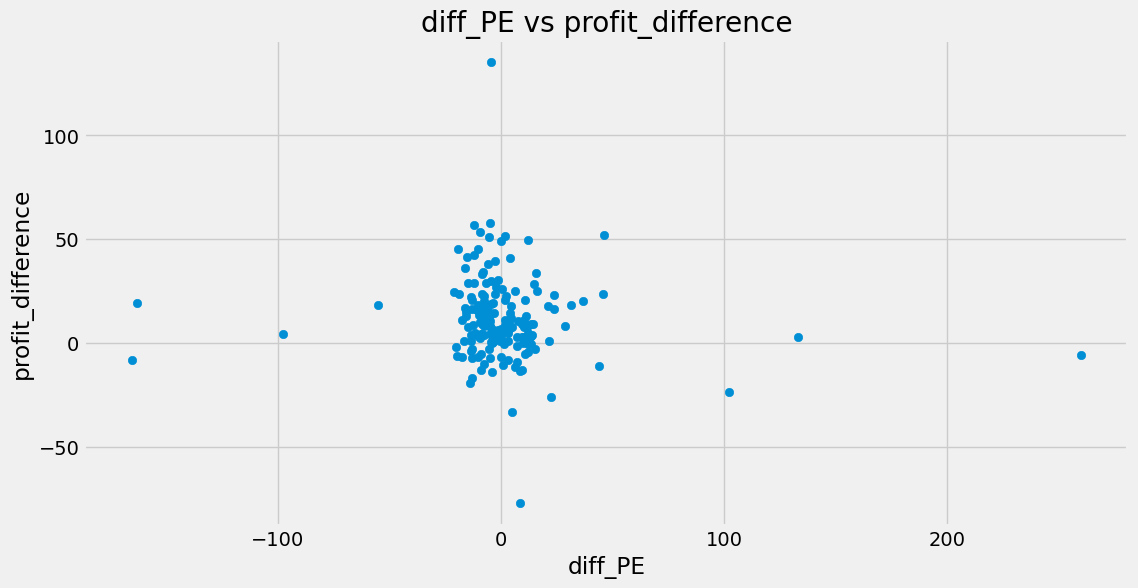

In [16]:
#plot diff_PE vs profit_difference
plt.scatter(df_ratio2['diff_PE'], df_ratio2['profit_difference'])
plt.xlabel('diff_PE')
plt.ylabel('profit_difference')
plt.title('diff_PE vs profit_difference')
plt.show()

The figure above plots the difference in the P/E ratio against the profit difference. The figure shows that there is not any linear correlation between the two variables, meaning that the P/E ratio might not have any effect on the profit difference. 

## Regression for WACC

In [17]:
df_wacc = final_merger[['ticker', 'wacc', 'sector', 'calendarYear']].dropna()
df_wacc_2 = df_wacc.groupby('sector')['wacc'].mean()
#merge with df
df_wacc= df_wacc.merge(df_wacc_2, how='left', left_on=['sector'], right_on=['sector'] )
#rename wacc_y to wacc_sector
df_wacc = df_wacc.rename(columns={'wacc_y': 'wacc_sector'})
df_wacc['diff_wacc'] =df_wacc['wacc_x']- df_wacc['wacc_sector']

In [18]:
df_wacc_profit = df_wacc.merge(profit_more_years_2019, how='left', left_on=['ticker'], right_on=['ticker'] ) # merge with profit_more_years_2019

df_wacc_profit = df_wacc_profit.dropna()

In [19]:
df_wacc_profit

,ticker,wacc_x,sector,calendarYear_x,wacc_sector,diff_wacc,Unnamed: 0,calendarYear_y,adjClose,profit_difference,actual_year_profit
0,AAPL,7.604556,Technology,2018,7.580196,0.024360,0,2018,66.384460,28.337417,2019
1,AMGN,7.658498,Healthcare,2018,6.514833,1.143665,1498,2018,214.043457,45.126602,2019
2,BA,8.731439,Industrials,2018,7.449745,1.281693,4494,2018,344.241882,29.596710,2019
3,CAT,6.804090,Industrials,2018,7.449745,-0.645655,5992,2018,135.719162,22.083702,2019
4,CVX,7.214262,Energy,2018,7.214262,0.000000,10486,2018,102.220711,10.704422,2019
5,DIS,6.890882,Communication Services,2018,5.124657,1.766225,11984,2018,146.880005,39.225662,2019
6,GS,2.095365,Financial Services,2018,5.341371,-3.246006,13669,2018,209.847000,53.373718,2019
7,HD,6.780889,Consumer Cyclical,2018,6.246941,0.533948,15167,2018,196.510834,40.964142,2019
8,HON,7.280449,Industrials,2018,7.449745,-0.169296,16665,2018,166.100082,45.122017,2019
9,IBM,5.121141,Technology,2018,7.580196,-2.459055,18163,2018,110.151093,20.661774,2019


In [20]:
X = df_wacc_profit['diff_wacc']
y = df_wacc_profit['profit_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      profit_difference   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.874
Date:                Wed, 24 May 2023   Prob (F-statistic):              0.184
Time:                        14:55:42   Log-Likelihood:                -110.09
No. Observations:                  26   AIC:                             224.2
Df Residuals:                      24   BIC:                             226.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9686      3.408      7.620      0.000      18.935      33.002
diff_wacc      3.3312      2.434      1.369      0.184      -1.691       8.354
==============================================================================
Omnibus:                        0.750   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.687   Jarque-Bera (JB):                0.198
Skew:                          -0.204   Prob(JB):                        0.906
Kurtosis:                       3.129   Cond. No.                         1.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As the previous OLS Regression result we have the same dependent variabel (profit_difference) but now the independet variabel is diff_wacc. This OLS has a higher R-squared value of 0.072, which indicates that 7.2% of the variance is explained by the independent value. The F-statistics of 1.874 indicates that the relationship between dependent and independent is not statistically significant. 

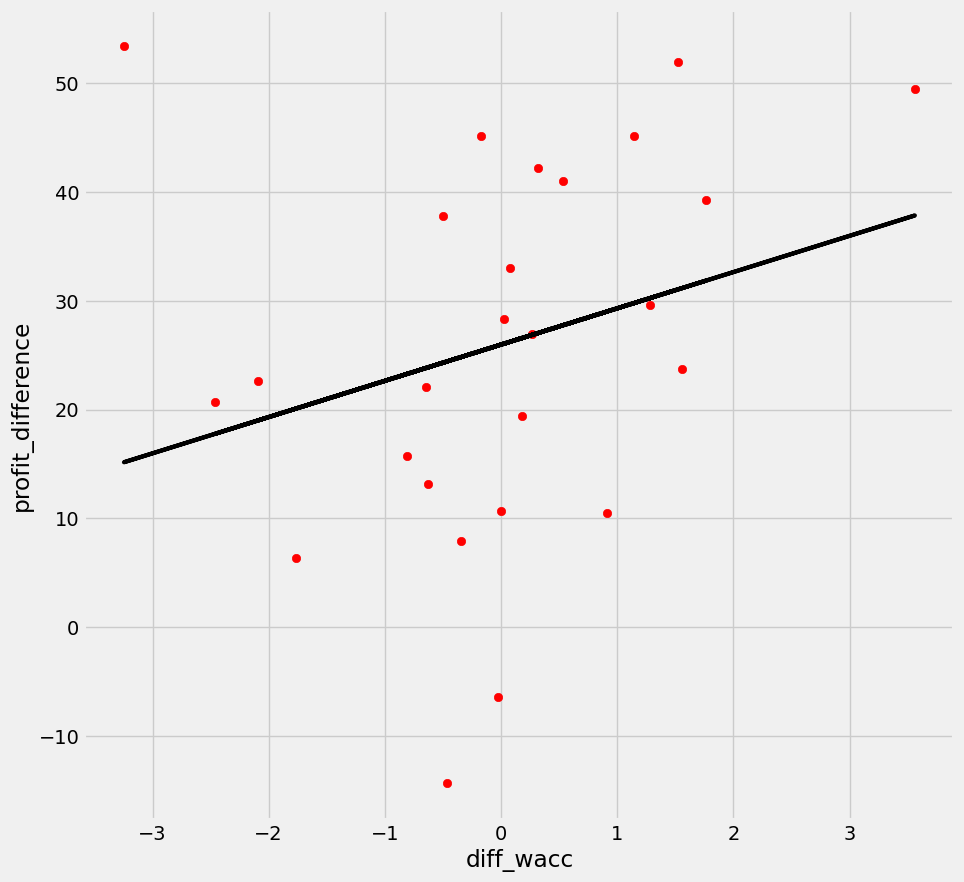

In [21]:
#plot the regression for diff_dcf_price and diff_wacc on profit_difference
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_wacc_profit['diff_wacc'], df_wacc_profit['profit_difference'], color='red')
ax.plot(X['diff_wacc'], predictions, color='black', linewidth=3)
ax.set_xlabel('diff_wacc')
ax.set_ylabel('profit_difference')
plt.show()


The figur above plots the wacc difference against the profit difference to see if there is any correlation between the two variables. The figure shows that there might not be any linear correlation between the two variables, meaning that the WACC might not have any effect on the profit difference.

## Regression for DCF

In [22]:
df_dcf['diff_dcf_price'] = df_dcf['dcf']-df_dcf['adjClose']
df_dcf = df_dcf.dropna()


In [23]:
X = df_dcf['diff_dcf_price']
y = df_dcf['profit_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

c:\Users\Birk\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      profit_difference   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     2.641
Date:                Wed, 24 May 2023   Prob (F-statistic):              0.126
Time:                        14:55:43   Log-Likelihood:                -62.507
No. Observations:                  16   AIC:                             129.0
Df Residuals:                      14   BIC:                             130.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             31.2481      3.656      8.547      0.000      23.406      39.090
diff_dcf_price     0.0568      0.035      1.625      0.126      -0.018       0.132
==============================================================================
Omnibus:                        0.876   Durbin-Watson:                   2.351
Prob(Omnibus):                  0.645   Jarque-Bera (JB):                0.682
Skew:                          -0.031   Prob(JB):                        0.711
Kurtosis:                       1.991   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As the previous OLS regression the dependent variabel remains the same but the independent variabel is now (diff_dcf_price). The R-squared value of 0.05 indicates again that the independent variabel is not a good fit. The F-statistics of 1.787 also indicate that the significance of the model is rather low and the same applies to the relationship between the dependent and independent variabel. 

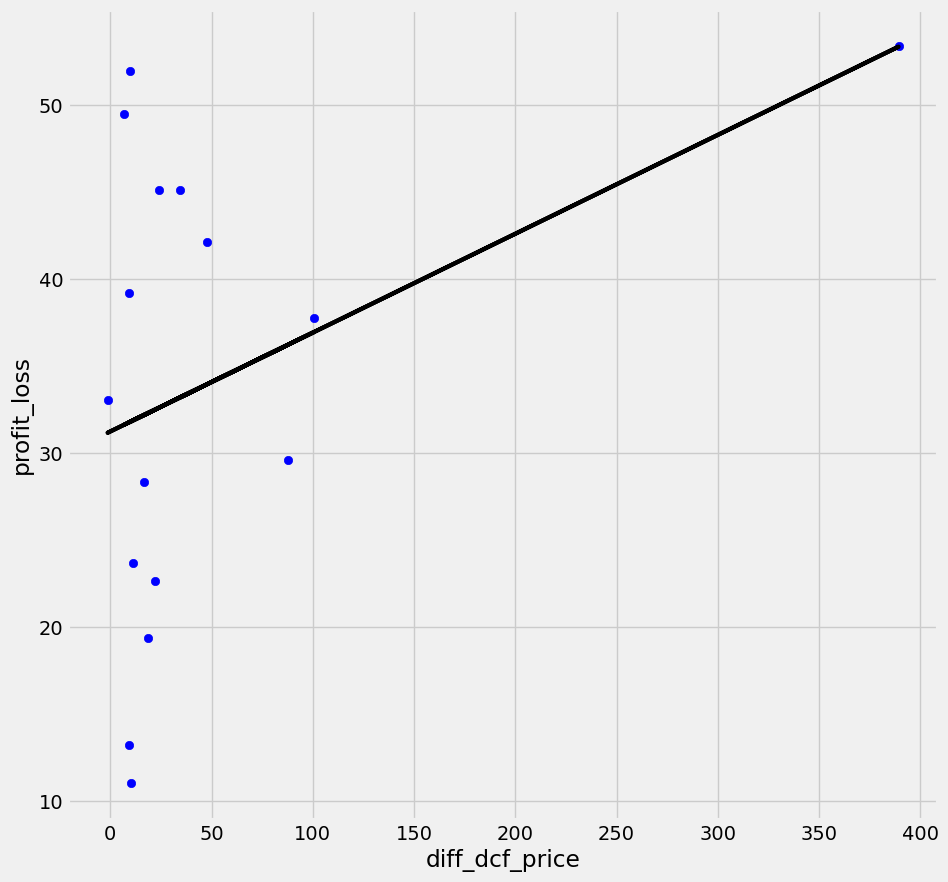

In [24]:
#plot the regression for diff_dcf_price and diff_wacc on profit_difference
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_dcf['diff_dcf_price'], df_dcf['profit_difference'], color='blue')

ax.plot(df_dcf['diff_dcf_price'], predictions, color='black', linewidth=3)

ax.set_xlabel('diff_dcf_price')
ax.set_ylabel('profit_loss')
plt.show()


The figure above plots the DCF difference against the profit difference to see if there is any correlation between the two variables. The figure shows that there might not be any linear correlation between the two variables, meaning that the DCF might not have any effect on the profit difference. 

## Prediction for ratios
In this section we provice predictions for the P/E ratio, P/S ratio, P/B ratio, DCF and WACC. We will simply subtract each of the ratios with the mean of the ratios. If the ratio is greater than the mean we predict that the profit difference will be positive and if the ratio is less than the mean we predict that the profit difference will be negative. Lastly, we compare these prediction to the actualt profit difference. For the ratios P/E, P/S and P/B we will predict for all the years 2014-2019 and for the DCF and WACC we will only predict for the year 2019.

In [25]:
# Create a new column in df_ratio2 using an if statement about, if diff_PE is positive and class_profit_difference is 1 assign 1 or if diff_PE is negative and class_profit_difference is 0 assign 1 else 0
df_ratio2['class_profit_difference'] = np.where(df_ratio2['profit_difference'] > 0, 1, 0)
df_ratio2['correct_pred_diff_PE'] = np.where((df_ratio2['diff_PE'] > 0) & (df_ratio2['class_profit_difference'] == 1), 1, np.where((df_ratio2['diff_PE'] < 0) & (df_ratio2['class_profit_difference'] == 0), 1, 0))
df_ratio2['correct_pred_diff_PS'] = np.where((df_ratio2['diff_PS'] > 0) & (df_ratio2['class_profit_difference'] == 1), 1, np.where((df_ratio2['diff_PS'] < 0) & (df_ratio2['class_profit_difference'] == 0), 1, 0))
df_ratio2['correct_pred_diff_PB'] = np.where((df_ratio2['diff_PB'] > 0) & (df_ratio2['class_profit_difference'] == 1), 1, np.where((df_ratio2['diff_PB'] < 0) & (df_ratio2['class_profit_difference'] == 0), 1, 0))

In [26]:
#df_ratio2
#counter number of 1s in correct_pred_diff_PE and correct_pred_diff_PS and correct_pred_diff_PB

#Show the percentage of correct predictions

#show them all in one table
#pd.concat([df_ratio2['correct_pred_diff_PE'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PS'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PB'].value_counts(normalize=True)*100], axis=1)

#inclue the correct_pred_diff_ROE
pd.concat([df_ratio2['correct_pred_diff_PE'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PS'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PB'].value_counts(normalize=True)*100], axis=1)

,correct_pred_diff_PE,correct_pred_diff_PS,correct_pred_diff_PB
0,56.287425,49.101796,59.281437
1,43.712575,50.898204,40.718563


The three metrics PE, PS, and PB illustrate the predicted values and actual values of each metric. PS predicts a value of 50.9 which is closest to the actual value of 49.1. 

## Prediction for WACC

In [27]:
#create a new column in df_ratio2 using an if statement about, if diff_PE is positive and class_profit_difference is 1 assign 1 or if diff_PE is negative and class_profit_difference is 0 assign 1 else 0
df_wacc_profit['class_profit_difference'] = np.where(df_wacc_profit['profit_difference'] > 0, 1, 0)
df_wacc_profit['correct_wacc'] = np.where((df_wacc_profit['diff_wacc'] > 0) & (df_wacc_profit['class_profit_difference'] == 1), 1, np.where((df_wacc_profit['diff_wacc'] < 0) & (df_wacc_profit['class_profit_difference'] == 0), 1, 0))

pd.concat([df_wacc_profit['correct_wacc'].value_counts(normalize=True)*100], axis=1)


,correct_wacc
1,57.692308
0,42.307692


In this prediction WACC predicts with a value of 42.3 where the actual value is 57.7. This means that it is predicting incorrectly 42.3% of the time. 

## Prediction for DCF

In [28]:
df_dcf

,dcf,sector,calendarYear,ticker,profit_difference,actual_year_profit_difference_2019,adjClose,actual_year_adjclose_2s019,diff_dcf_price
0,54.37,Technology,2018,AAPL,28.337417,2019,38.003681,2018,16.366319
6,195.37,Healthcare,2018,AMGN,45.126602,2019,171.355103,2018,24.014897
12,85.11,Consumer Cyclical,2018,AMZN,11.060005,2019,75.098503,2018,10.011497
18,400.90,Industrials,2018,BA,29.596710,2019,313.372253,2018,87.527747
42,117.53,Communication Services,2018,DIS,39.225662,2019,108.326126,2018,9.203874
48,541.21,Financial Services,2018,GS,53.373718,2019,151.943588,2018,389.266412
60,155.78,Industrials,2018,HON,45.122017,2019,121.244179,2018,34.535821
83,186.49,Financial Services,2018,JPM,37.788147,2019,85.749496,2018,100.740504
95,182.90,Consumer Cyclical,2018,MCD,22.631668,2019,160.827148,2018,22.072852
107,73.08,Healthcare,2018,MRK,13.201568,2019,63.870434,2018,9.209566


In [29]:
#create a new column in df_ratio2 using an if statement about, if diff_PE is positive and class_profit_difference is 1 assign 1 or if diff_PE is negative and class_profit_difference is 0 assign 1 else 0
df_dcf['class_profit_difference'] = np.where(df_dcf['profit_difference'] > 0, 1, 0)
df_dcf['correct_dcf'] = np.where((df_dcf['diff_dcf_price'] > 0) & (df_dcf['class_profit_difference'] == 1), 1, np.where((df_dcf['diff_dcf_price'] < 0) & (df_dcf['class_profit_difference'] == 0), 1, 0))

dcf_pred = pd.concat([df_dcf['correct_dcf'].value_counts(normalize=True)*100], axis=1)


In [30]:
dcf_pred

,correct_dcf
1,93.75
0,6.25


Our DCF predictions indicates that it predicts correctly 94% of the time. 

## Conclusion
Based on a 5% significance level, it can be concluded that the three OLS regression models for the financial ratios, DCF, and WACC are not statistically significant. This implies that these variables are not reliable predictors of the expected return. However, it should be noted that the DCF predictions were accurate 94% of the time, suggesting that DCF could still be a useful predictor for the expected return.

On the other hand, the predictions for the other variables performed poorly, which is consistent with the OLS regression results. It is important to keep in mind that this project is based on a small dataset, and the results may differ if a larger dataset is used. Therefore, further research is needed to determine whether financial ratios, DCF, and WACC are indeed poor or good predictors for the expected return.